# Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..','..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.data.polarisation import PolarisationFrame
from arl.visibility.base import create_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits, smooth_image
from arl.image.deconvolution import deconvolve_cube, restore_cube
from arl.image.iterators import  image_raster_iter
from arl.image.solvers import solve_image
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, create_low_test_image_composite, \
    create_low_test_beam
from arl.imaging.imaging_context import invert_function, predict_function
from arl.imaging.weighting import weight_visibility

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct LOW configuration

In [2]:
low = create_named_configuration('LOWBD2-CORE')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
config = 'core'
if config == 'full':
    low = create_named_configuration('LOWBD2')
    b = 8e4
    cellsize = 0.00001
    npixel=10 * 2048
    padding = 1
    context = '2d'
    kernel='2d'

else:
    low = create_named_configuration('LOWBD2-CORE')
    b = 4e3
    cellsize = 0.001
    npixel=256
    padding = 2
    context='2d'
    kernel='wprojection'
    

    
oversampling = 32

frequency = numpy.linspace(0.99e8, 1.01e8, 3)
channel_bandwidth=numpy.array([1e6, 1e6, 1e6])
times = numpy.linspace(-3, +3, 15) * numpy.pi / 12.0
log.info('Observing times %s' % (times))

log.info("Observing frequencies %s Hz" % (frequency))

log.info("Cellsize = %.6f radians" % (cellsize))

Observing times [-0.78539816 -0.67319843 -0.56099869 -0.44879895 -0.33659921 -0.22439948
 -0.11219974  0.          0.11219974  0.22439948  0.33659921  0.44879895
  0.56099869  0.67319843  0.78539816]
Observing frequencies [  9.90000000e+07   1.00000000e+08   1.01000000e+08] Hz
Cellsize = 0.001000 radians


In [4]:
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(low, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 616275 rows, 0.064 GB


Plot the synthesized uv coverage, including for MFS

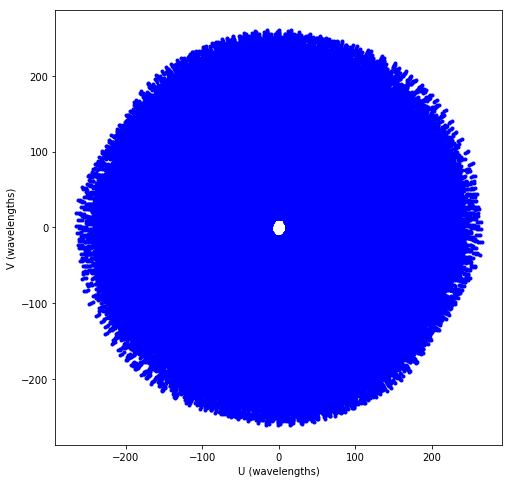

In [6]:
plt.clf()
plt.plot(vt.uvw[:,0],   vt.uvw[:,1], '.', color='b')
plt.plot(-vt.uvw[:,0], -vt.uvw[:,1], '.', color='b')
plt.xlabel("U (wavelengths)")
plt.ylabel("V (wavelengths)")
plt.show()

Make a test image

In [10]:
model = create_low_test_image_composite(npixel=npixel, frequency=frequency, channel_bandwidth=channel_bandwidth,
                                         cellsize=cellsize, 
                                         phasecentre=phasecentre)
export_image_to_fits(model, '%s/imaging-low-model.fits' % (results_dir))

create_low_test_image_from_gleam: 4137 sources inside the image
create_low_test_image_from_gleam: Average flux per channel in image = 1352.947
create_low_test_image_from_s3: 78612 sources inside the image
create_low_test_image_from_s3: average channel flux in S3 model = 5793.205, actual average channel flux in image = 2664.269


import_image_from_fits: created >f4 image of shape (1, 1, 256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/SKA1_LOW_beam.fits = 0.997918, 0.000000
create_low_test_beam: primary beam is defined at 100.000 MHz
Model * beam has 204.312 Jy


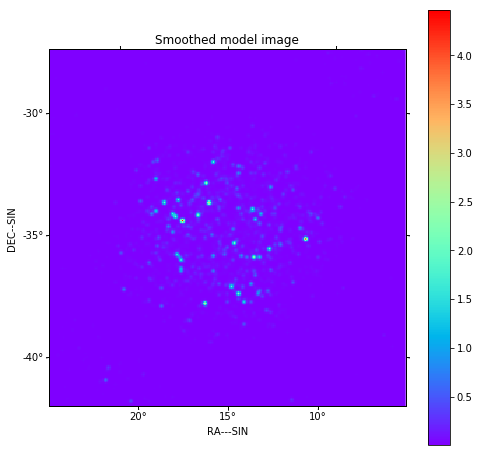

In [10]:
beam=create_low_test_beam(model)
model.data*=beam.data
print("Model * beam has %.3f Jy" % (numpy.sum(model.data[0,0,:,:])))
cmodel = smooth_image(model)
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()
export_image_to_fits(cmodel, '%s/imaging-low-cmodel.fits' % (results_dir))
beam = None
cmodel = None

predict_with_iterators: Processing chunks
predict_2d: predict using 2d transform
get_kernel_list: Using wprojection kernel
get_kernel_list: Using wprojection kernel
get_kernel_list: Fresnel number = 16.384000
get_kernel_list: Fresnel number = 16.384000
advise_wide_field: Maximum wavelength 3.028 (meters)
advise_wide_field: Minimum wavelength 2.968 (meters)
advise_wide_field: Maximum baseline 265.3 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.086520 (rad) 4.957 (deg)
advise_wide_field: Image field of view 0.519121 (rad) 29.743 (deg)
advise_wide_field: Synthesized beam 0.003770 (rad) 0.216 (deg)
advise_wide_field: Cellsize 0.001257 (rad) 0.072 (deg)
advice_wide_field: Npixels per side = 413
advice_wide_field: Npixels (power of 2, 3) per side = 512
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.5 (wavelengths)
advice_wide_field: Time sampling for full image = 2

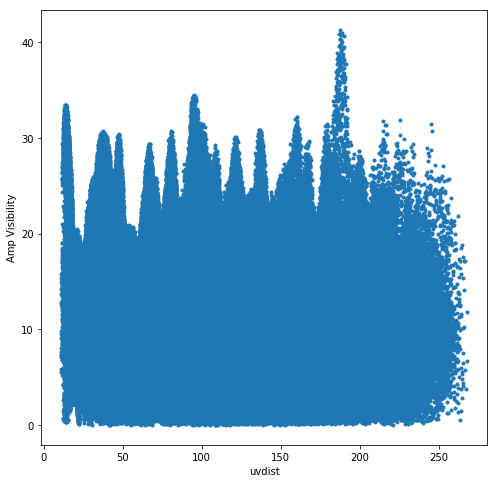

In [11]:
vt.data['vis'] *= 0.0
vt = predict_function(vt, model, context=context, kernel=kernel, padding=1)

# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

From now on, we will work with MFS images

In [12]:
from arl.imaging.base import create_image_from_visibility
model = create_image_from_visibility(vt, npixel=npixel, nchan=1, phasecentre=phasecentre, 
                                     cellsize=cellsize)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -35.)>, starting frequency 99000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 265.261057 wavelengths
create_image_from_visibility: Critical cellsize = 0.001885 radians, 0.107999 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees


Weight the data

weight_gridding: Performing uniform weighting


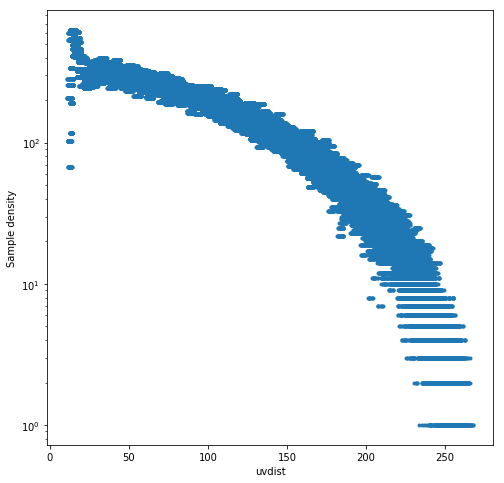

In [13]:
vt, density, densitygrid = weight_visibility(vt, model)
plt.clf()
plt.semilogy(uvdist, density, '.')
plt.xlabel('uvdist')
plt.ylabel('Sample density')
plt.show()
density = None
densitygrid = None

Make the dirty image and point spread function

invert_2d: inverting using 2d transform
get_kernel_list: Using wprojection kernel
get_kernel_list: Using wprojection kernel
get_kernel_list: Fresnel number = 16.384000
get_kernel_list: Fresnel number = 16.384000
advise_wide_field: Maximum wavelength 3.028 (meters)
advise_wide_field: Minimum wavelength 2.968 (meters)
advise_wide_field: Maximum baseline 265.3 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.086520 (rad) 4.957 (deg)
advise_wide_field: Image field of view 0.519121 (rad) 29.743 (deg)
advise_wide_field: Synthesized beam 0.003770 (rad) 0.216 (deg)
advise_wide_field: Cellsize 0.001257 (rad) 0.072 (deg)
advice_wide_field: Npixels per side = 413
advice_wide_field: Npixels (power of 2, 3) per side = 512
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.5 (wavelengths)
advice_wide_field: Time sampling for full image = 24.5 (s)
advice_wide_field: Time sampling 

create_w_term_image: For w = -16.9, field of view = 0.256000, Fresnel number = 0.28
create_w_term_image: For w = -8.4, field of view = 0.256000, Fresnel number = 0.14
create_w_term_image: For w = 0.0, field of view = 0.256000, Fresnel number = 0.00
create_w_term_image: For w = 8.4, field of view = 0.256000, Fresnel number = 0.14
create_w_term_image: For w = 16.9, field of view = 0.256000, Fresnel number = 0.28
create_w_term_image: For w = 25.3, field of view = 0.256000, Fresnel number = 0.41
create_w_term_image: For w = 33.7, field of view = 0.256000, Fresnel number = 0.55
create_w_term_image: For w = 42.2, field of view = 0.256000, Fresnel number = 0.69
create_w_term_image: For w = 50.6, field of view = 0.256000, Fresnel number = 0.83
create_w_term_image: For w = 59.0, field of view = 0.256000, Fresnel number = 0.97
create_w_term_image: For w = 67.4, field of view = 0.256000, Fresnel number = 1.11
create_w_term_image: For w = 75.9, field of view = 0.256000, Fresnel number = 1.24
creat

advice_wide_field: Number of planes in w projection 1
advice_wide_field: Recommend 2d gridding (i.e. no wprojection)
get_kernel_list: Using w projection with wstep = 8.504430
get_kernel_list: Using w projection with wstep = 8.504430, wmax = 168.621211
get_kernel_list: Maximum w kernel full width = 12 pixels
get_kernel_list: Maximum w kernel full width = 12 pixels
w_kernel_list: Maximum absolute w = 168.6, step is 8.5 wavelengths
create_w_term_image: For w = -168.6, field of view = 0.256000, Fresnel number = 2.76
create_w_term_image: For w = -160.2, field of view = 0.256000, Fresnel number = 2.62
create_w_term_image: For w = -151.8, field of view = 0.256000, Fresnel number = 2.49
create_w_term_image: For w = -143.3, field of view = 0.256000, Fresnel number = 2.35
create_w_term_image: For w = -134.9, field of view = 0.256000, Fresnel number = 2.21
create_w_term_image: For w = -126.5, field of view = 0.256000, Fresnel number = 2.07
create_w_term_image: For w = -118.0, field of view = 0.25

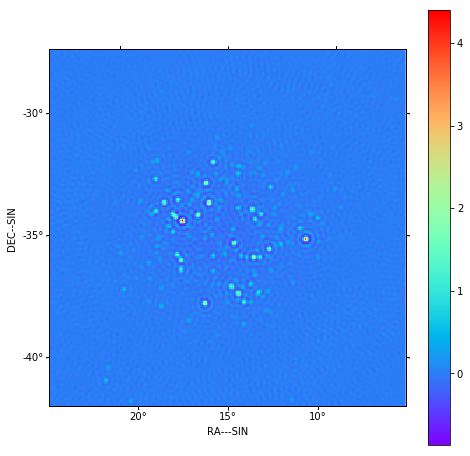

In [14]:
dirty, sumwt = invert_function(vt, model, context=context, kernel=kernel, padding=1)
show_image(dirty)

psf, sumwt = invert_function(vt, model, dopsf=True, context=context, kernel=kernel, padding=1)


print("Max, min in dirty image = %.6f, %.6f, sumwt = %s" % (dirty.data.max(), dirty.data.min(), sumwt))
print("Max, min in PSF         = %.6f, %.6f, sumwt = %s" % (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging-low-dirty.fits' % (results_dir))
export_image_to_fits(psf, '%s/imaging-low-psf.fits' % (results_dir))

dirty = None

Do some major cycles

solve_image: Performing 5 major cycles
predict_with_iterators: Processing chunks
predict_2d: predict using 2d transform
get_kernel_list: Using wprojection kernel
get_kernel_list: Using wprojection kernel
get_kernel_list: Fresnel number = 16.384000
get_kernel_list: Fresnel number = 16.384000
advise_wide_field: Maximum wavelength 3.028 (meters)
advise_wide_field: Minimum wavelength 2.968 (meters)
advise_wide_field: Maximum baseline 265.3 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.086520 (rad) 4.957 (deg)
advise_wide_field: Image field of view 0.519121 (rad) 29.743 (deg)
advise_wide_field: Synthesized beam 0.003770 (rad) 0.216 (deg)
advise_wide_field: Cellsize 0.001257 (rad) 0.072 (deg)
advice_wide_field: Npixels per side = 413
advice_wide_field: Npixels (power of 2, 3) per side = 512
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.5 (wavelengths)
advice_wide_

create_w_term_image: For w = -25.3, field of view = 0.512000, Fresnel number = 1.66
create_w_term_image: For w = -16.9, field of view = 0.512000, Fresnel number = 1.11
create_w_term_image: For w = -8.4, field of view = 0.512000, Fresnel number = 0.55
create_w_term_image: For w = 0.0, field of view = 0.512000, Fresnel number = 0.00
create_w_term_image: For w = 8.4, field of view = 0.512000, Fresnel number = 0.55
create_w_term_image: For w = 16.9, field of view = 0.512000, Fresnel number = 1.11
create_w_term_image: For w = 25.3, field of view = 0.512000, Fresnel number = 1.66
create_w_term_image: For w = 33.7, field of view = 0.512000, Fresnel number = 2.21
create_w_term_image: For w = 42.2, field of view = 0.512000, Fresnel number = 2.76
create_w_term_image: For w = 50.6, field of view = 0.512000, Fresnel number = 3.32
create_w_term_image: For w = 59.0, field of view = 0.512000, Fresnel number = 3.87
create_w_term_image: For w = 67.4, field of view = 0.512000, Fresnel number = 4.42
crea

advice_wide_field: Frequency sampling for primary beam = 1030725.9 (Hz)
advice_wide_field: Number of planes in w stack 31
advice_wide_field: Number of planes in w projection 1
advice_wide_field: Recommend 2d gridding (i.e. no wprojection)
get_kernel_list: Using w projection with wstep = 8.504430
get_kernel_list: Using w projection with wstep = 8.504430, wmax = 168.621211
get_kernel_list: Maximum w kernel full width = 22 pixels
get_kernel_list: Maximum w kernel full width = 22 pixels
w_kernel_list: Maximum absolute w = 168.6, step is 8.5 wavelengths
create_w_term_image: For w = -168.6, field of view = 0.512000, Fresnel number = 11.05
create_w_term_image: For w = -160.2, field of view = 0.512000, Fresnel number = 10.50
create_w_term_image: For w = -151.8, field of view = 0.512000, Fresnel number = 9.95
create_w_term_image: For w = -143.3, field of view = 0.512000, Fresnel number = 9.39
create_w_term_image: For w = -134.9, field of view = 0.512000, Fresnel number = 8.84
create_w_term_imag

create_w_term_image: For w = 92.7, field of view = 0.512000, Fresnel number = 6.08
create_w_term_image: For w = 101.2, field of view = 0.512000, Fresnel number = 6.63
create_w_term_image: For w = 109.6, field of view = 0.512000, Fresnel number = 7.18
create_w_term_image: For w = 118.0, field of view = 0.512000, Fresnel number = 7.74
create_w_term_image: For w = 126.5, field of view = 0.512000, Fresnel number = 8.29
create_w_term_image: For w = 134.9, field of view = 0.512000, Fresnel number = 8.84
create_w_term_image: For w = 143.3, field of view = 0.512000, Fresnel number = 9.39
create_w_term_image: For w = 151.8, field of view = 0.512000, Fresnel number = 9.95
create_w_term_image: For w = 160.2, field of view = 0.512000, Fresnel number = 10.50
create_w_term_image: For w = 168.6, field of view = 0.512000, Fresnel number = 11.05
solve_image: Start of major cycle 0
deconvolve_cube: Hogbom clean of each polarisation and channel separately
deconvolve_cube: Processing pol 0, channel 0
hogb

create_w_term_image: For w = -151.8, field of view = 0.512000, Fresnel number = 9.95
create_w_term_image: For w = -143.3, field of view = 0.512000, Fresnel number = 9.39
create_w_term_image: For w = -134.9, field of view = 0.512000, Fresnel number = 8.84
create_w_term_image: For w = -126.5, field of view = 0.512000, Fresnel number = 8.29
create_w_term_image: For w = -118.0, field of view = 0.512000, Fresnel number = 7.74
create_w_term_image: For w = -109.6, field of view = 0.512000, Fresnel number = 7.18
create_w_term_image: For w = -101.2, field of view = 0.512000, Fresnel number = 6.63
create_w_term_image: For w = -92.7, field of view = 0.512000, Fresnel number = 6.08
create_w_term_image: For w = -84.3, field of view = 0.512000, Fresnel number = 5.53
create_w_term_image: For w = -75.9, field of view = 0.512000, Fresnel number = 4.97
create_w_term_image: For w = -67.4, field of view = 0.512000, Fresnel number = 4.42
create_w_term_image: For w = -59.0, field of view = 0.512000, Fresnel

create_w_term_image: For w = 160.2, field of view = 0.512000, Fresnel number = 10.50
create_w_term_image: For w = 168.6, field of view = 0.512000, Fresnel number = 11.05
solve_image: End of major cycle
solve_image: Start of major cycle 1
deconvolve_cube: Hogbom clean of each polarisation and channel separately
deconvolve_cube: Processing pol 0, channel 0
hogbom: Max abs in dirty image = 0.134731
hogbom: Start of minor cycle
hogbom: This minor cycle will stop at 10000 iterations or peak < 0.05
hogbom: Max abs in dirty Image = 0.134731
hogbom: Minor cycle 0, peak -0.134731446655 at [128, 128]
hogbom: Stopped at iteration 9, peak -0.046977950652 at [128, 128]
hogbom: End of minor cycle
predict_with_iterators: Processing chunks
predict_2d: predict using 2d transform
get_kernel_list: Using wprojection kernel
get_kernel_list: Using wprojection kernel
get_kernel_list: Fresnel number = 16.384000
get_kernel_list: Fresnel number = 16.384000
advise_wide_field: Maximum wavelength 3.028 (meters)
ad

create_w_term_image: For w = -92.7, field of view = 0.512000, Fresnel number = 6.08
create_w_term_image: For w = -84.3, field of view = 0.512000, Fresnel number = 5.53
create_w_term_image: For w = -75.9, field of view = 0.512000, Fresnel number = 4.97
create_w_term_image: For w = -67.4, field of view = 0.512000, Fresnel number = 4.42
create_w_term_image: For w = -59.0, field of view = 0.512000, Fresnel number = 3.87
create_w_term_image: For w = -50.6, field of view = 0.512000, Fresnel number = 3.32
create_w_term_image: For w = -42.2, field of view = 0.512000, Fresnel number = 2.76
create_w_term_image: For w = -33.7, field of view = 0.512000, Fresnel number = 2.21
create_w_term_image: For w = -25.3, field of view = 0.512000, Fresnel number = 1.66
create_w_term_image: For w = -16.9, field of view = 0.512000, Fresnel number = 1.11
create_w_term_image: For w = -8.4, field of view = 0.512000, Fresnel number = 0.55
create_w_term_image: For w = 0.0, field of view = 0.512000, Fresnel number = 

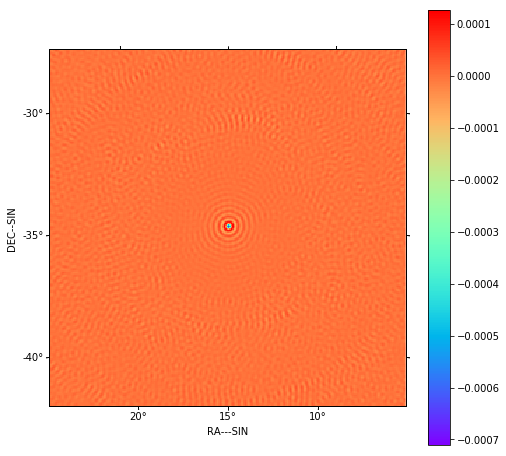

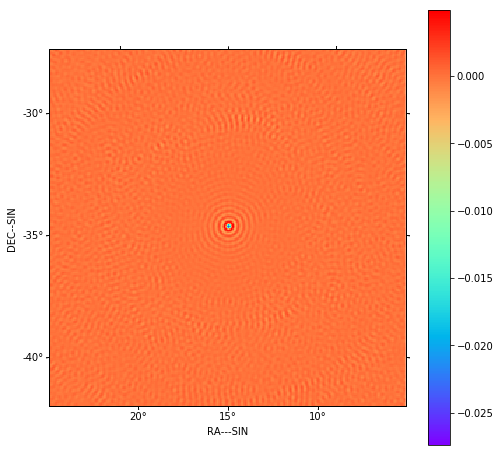

In [15]:
model.data[...] = 0.0
vtres, comp, residual = solve_image(vt, model, niter=10000, fractional_threshold=0.1, 
                                    threshold=0.050, nmajor=5, gain=0.1, 
                                    algorithm='hogbom', padding=padding,
                                    context=context, kernel=kernel)

fig=show_image(comp)
fig=show_image(residual)

The fit may be unsuccessful; check fit_info['message'] for more information.
restore_cube: error in fitting to psf, using 1 pixel stddev


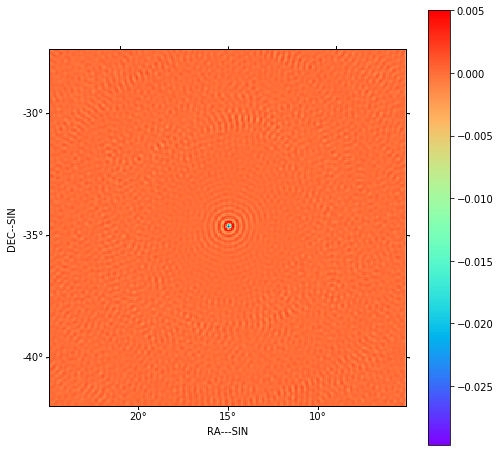

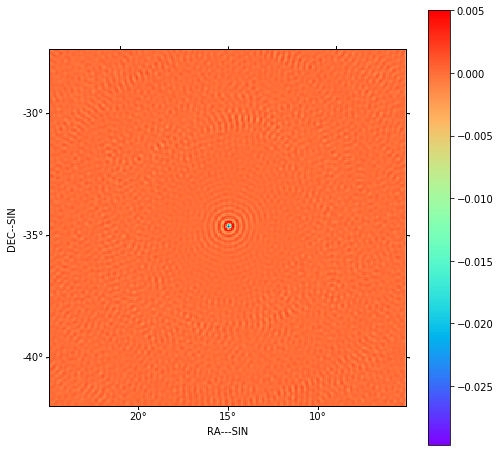

In [16]:
clean = restore_cube(model=comp, psf=psf, residual=residual)
export_image_to_fits(clean, '%s/imaging-low-clean.fits' % (results_dir))
show_image(clean)

Predict the visibility of the model

In [17]:
vtmodel = create_visibility(low, times, frequency, channel_bandwidth=channel_bandwidth,
                            weight=1.0, phasecentre=phasecentre, 
                            polarisation_frame=PolarisationFrame('stokesI'))
vtmodel=predict_function(vtmodel, comp, context=context, kernel=kernel, timeslice=1.0)

create_visibility: 616275 rows, 0.064 GB
predict_with_iterators: Processing chunks
predict_2d: predict using 2d transform
get_kernel_list: Using wprojection kernel
get_kernel_list: Using wprojection kernel
get_kernel_list: Fresnel number = 16.384000
get_kernel_list: Fresnel number = 16.384000
advise_wide_field: Maximum wavelength 3.028 (meters)
advise_wide_field: Minimum wavelength 2.968 (meters)
advise_wide_field: Maximum baseline 265.3 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.086520 (rad) 4.957 (deg)
advise_wide_field: Image field of view 0.519121 (rad) 29.743 (deg)
advise_wide_field: Synthesized beam 0.003770 (rad) 0.216 (deg)
advise_wide_field: Cellsize 0.001257 (rad) 0.072 (deg)
advice_wide_field: Npixels per side = 413
advice_wide_field: Npixels (power of 2, 3) per side = 512
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.5 (wavelengths)
advice_wid

Now we will plot the original visibility and the residual visibility.

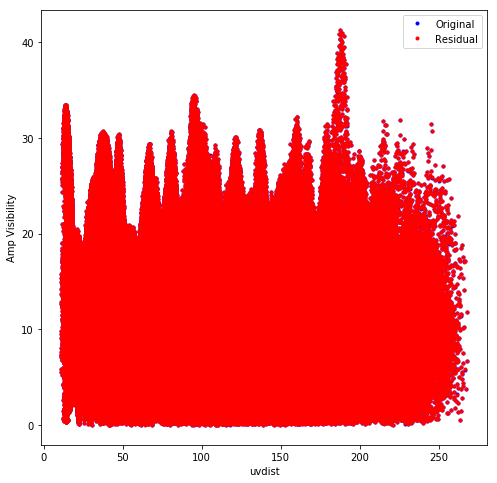

In [18]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.', color='b', label='Original')
plt.plot(uvdist, numpy.abs(vt.data['vis']-vtmodel.data['vis']), '.', color='r', 
         label='Residual')

plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.legend()
plt.show()